In [39]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [58]:
#Load the dataset
df = pd.read_csv('/Users/gupilteki/Downloads/bankloans.csv')
print(df.head())

   cid  age  employ  address  income  debtinc   creddebt   othdebt  default
0    1   41      17       12     176      9.3  11.359392  5.008608        8
1    2   27      10        6      31     17.3   1.362202  4.000798        8
2    3   40      15       14      55      5.5   0.856075  2.168925        4
3    4   41      15       14     120      2.9   2.658720  0.821280        6
4    5   24       2        0      28     17.3   1.787436  3.056564        4


In [42]:
#Drop missing defaults & employ with employ = 0
df_clean = df.dropna(subset=["default"])
df_clean = df_clean[df_clean["employ"] != 0].copy()


In [57]:
#borrower risk levels
def risk_value(value):
    if value <= 1:
        return "Safe"
    elif value == 2:
        return "Risky"
    elif value == 3:
        return "Super Risky"
    else:
        return "No More Credit"
df_clean["risk_category"] = df_clean["default"].apply(risk_value)
risk_summary = df_clean["risk_category"].value_counts().reset_index()
risk_summary.columns = ["Risk Category", "Number of Borrowers"]



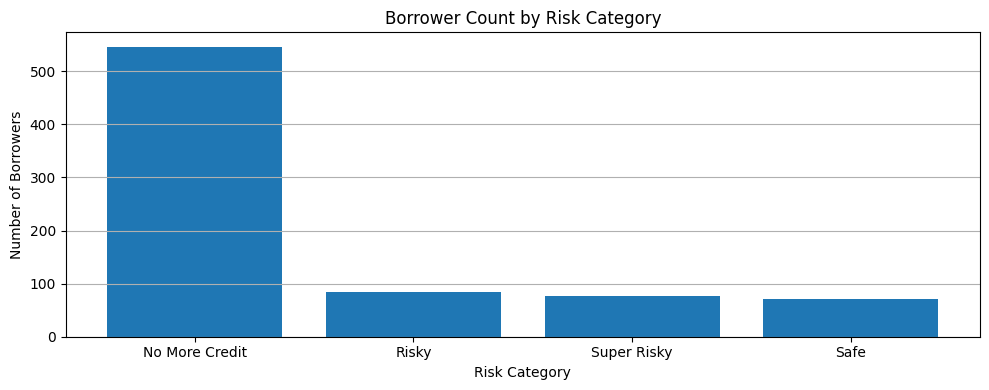

In [44]:
plt.figure(figsize=(10, 4))
plt.bar(risk_summary["Risk Category"], risk_summary["Number of Borrowers"])
plt.xlabel("Risk Category")
plt.ylabel("Number of Borrowers")
plt.title("Borrower Count by Risk Category")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [45]:
#Summarize risk category counts
print("\nRisk Summary Table:\n", risk_summary)


Risk Summary Table:
     Risk Category  Number of Borrowers
0  No More Credit                  546
1           Risky                   84
2     Super Risky                   77
3            Safe                   71


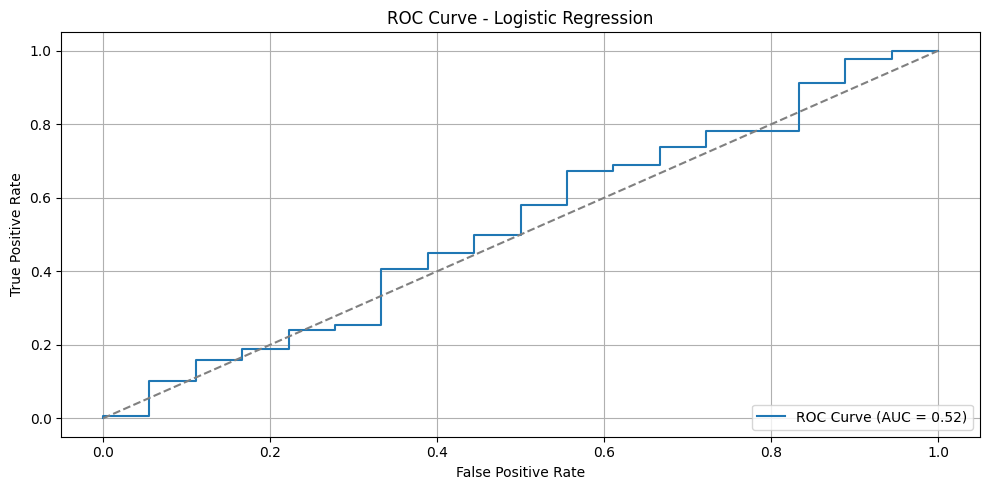

In [46]:
#Logistic Regression
#Binary classification setup (Safe vs Risky+)
X = df_clean[["age", "income", "debtinc", "creddebt", "othdebt"]]
y=df_clean.loc[:, "default_binary"] = (df_clean["default"] > 1).astype(int)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict probabilities for the positive class
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

In [47]:
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.88      1.00      0.94       138

    accuracy                           0.88       156
   macro avg       0.44      0.50      0.47       156
weighted avg       0.78      0.88      0.83       156


Confusion Matrix:
 [[  0  18]
 [  0 138]]


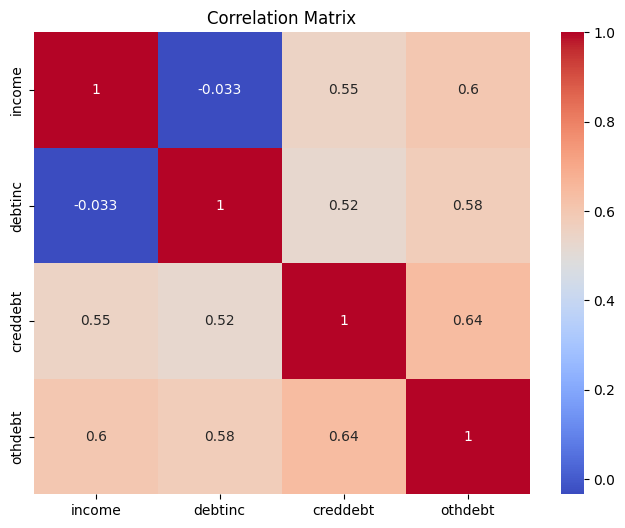

In [48]:
#Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[["income", "debtinc", "creddebt", "othdebt"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [49]:
#Logistic Regression Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance (coef)": log_reg.coef_[0]
})
print("\nLogistic Regression Feature Importance:\n", feature_importance)


Logistic Regression Feature Importance:
     Feature  Importance (coef)
0       age          -0.001129
1    income          -0.006751
2   debtinc           0.022592
3  creddebt          -0.005516
4   othdebt           0.026206


In [50]:
#Regression Tree
reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X_train, df_clean.loc[y_train.index, "default"])
predicted_defaults = reg_tree.predict(X_test)



In [51]:
#KMeans Segmentation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean["cluster"] = kmeans.fit_predict(X_scaled)

print("\n📍 KMeans Segmentation (Cluster counts):\n", df_clean["cluster"].value_counts())




📍 KMeans Segmentation (Cluster counts):
 cluster
2    359
0    232
1    161
3     26
Name: count, dtype: int64


In [52]:
#Employee Risk Ratings
risky_loans = df_clean[df_clean["risk_category"] != "Safe"]
employee_risk_counts = risky_loans.groupby("employ").size().reset_index(name="risky_loan_count")




In [53]:
def rate_employee(risk_count):
    if risk_count == 0:
        return "Excellent"
    elif risk_count < 5:
        return "Great"
    elif 5 <= risk_count < 8:
        return "Good"
    else:
        return "Poor"

employee_risk_counts["rating"] = employee_risk_counts["risky_loan_count"].apply(rate_employee)
employee_rating_table = employee_risk_counts[["employ", "rating"]]

print("\n👤 Employee Ratings:\n", employee_rating_table.sort_values(by="employ").reset_index(drop=True))




👤 Employee Ratings:
     employ rating
0        1   Poor
1        2   Poor
2        3   Poor
3        4   Poor
4        5   Poor
5        6   Poor
6        7   Poor
7        8   Poor
8        9   Poor
9       10   Poor
10      11   Poor
11      12   Poor
12      13   Poor
13      14   Poor
14      15   Poor
15      16   Poor
16      17   Poor
17      18   Poor
18      19   Poor
19      20   Good
20      21   Poor
21      22   Poor
22      23   Good
23      24  Great
24      25  Great
25      26  Great
26      27  Great
27      28  Great
28      29  Great
29      30  Great
30      31  Great
31      33  Great
